In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, ZeroPadding2D, Activation, add, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [3]:
# re-size all the images
IMAGE_SIZE = [224,224]

# training config
epochs = 16
batch_size = 128

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/blood_cell_images.zip

--2023-08-06 17:56:33--  https://lazyprogrammer.me/course_files/blood_cell_images.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109834540 (105M) [application/zip]
Saving to: ‘blood_cell_images.zip’

blood_cell_images.z 100%[===================>] 104.75M  10.5MB/s    in 14s     

2023-08-06 17:56:48 (7.62 MB/s) - ‘blood_cell_images.zip’ saved [109834540/109834540]



In [5]:
!unzip -nq blood_cell_images.zip

In [6]:
!ls

blood_cell_images  blood_cell_images.zip  __MACOSX  sample_data


In [7]:
train_path = 'blood_cell_images/TRAIN'
valid_path = 'blood_cell_images/TEST'

In [8]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [9]:
# useful for getting the number of classes
folders = glob(train_path + '/*')

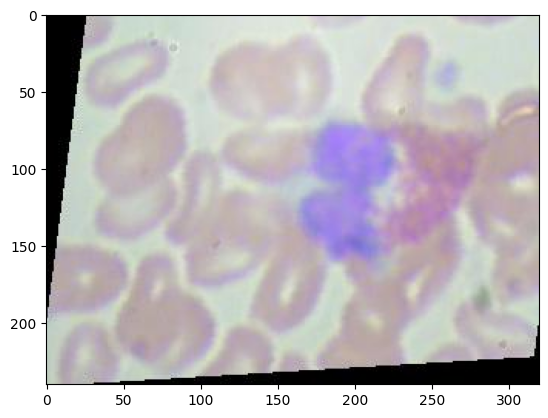

In [10]:
# llok at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [11]:
def identity_block(input_, kernel_size, filters):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1),
               # kernel_initializer='he_normal'
               )(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same',
               # kernel_initializer='he_normal
               )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1),
               # kernel_initializer='he_normal
               )(x)
    x = BatchNormalization()(x)

    x = add([x, input_])
    x = Activation('relu')(x)
    return x

In [12]:
def conv_block(input_,
               kernel_size,
               filters,
               strides=(2,2)):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1), strides=strides,
               # kernel_initializer='he_normal'
               )(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same',
               # kernel_initializer='he_normal'
               )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1),
               # kernel_initializer='he_normal'
               )(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(f3, (1, 1), strides=strides,
                      # kernel_initializer='he_normal
                      )(input_)
    shortcut = BatchNormalization()(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [13]:
# our custom resnet
i = Input(shape=IMAGE_SIZE + [3])
x = ZeroPadding2D(padding=(3, 3))(i)
x = Conv2D(64, (7, 7),
           strides=(2, 2),
           padding='valid',
           # kernel_initializer='he_normal'
           )(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], strides=(1,1))
x = identity_block(x, 3, [64, 64, 256])
x = identity_block(x, 3, [64, 64, 256])

x = conv_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])

In [14]:
# our layers - yuo can add more if u want
x = Flatten()(x)
# x = Dense(1000, activation='relu)(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [15]:
# create a model object
model = Model(inputs=i, outputs=prediction)

In [16]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [17]:
# tell the model what cost and optimization method to use
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [18]:
# create an instance of ImageDataGenerator
def preprocess_input2(x):
  x /= 127.5
  x -= 1.
  return x

train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input2
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input2
)

In [19]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE, class_mode='sparse')
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


min: -1.0 max: 0.9843137


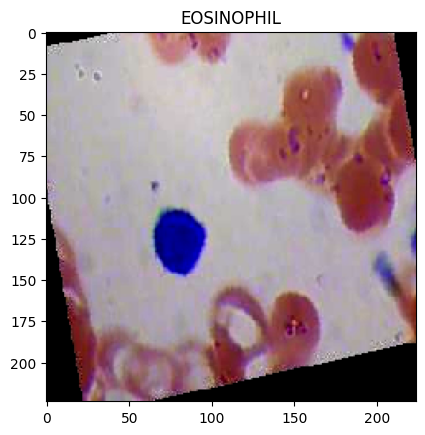

In [20]:
# should be NOT a strangely colored iage
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [21]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    class_mode='sparse'
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [22]:
# fit the model
checkpoint_filepath = '/tmp/checkpoint'
r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(valid_image_files) // batch_size,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True),
    ]
)




Epoch 1/16
77/77 [==============================] - 197s 2s/step - loss: 8.5825 - accuracy: 0.2825 - val_loss: 1.4685 - val_accuracy: 0.2504
Epoch 2/16
77/77 [==============================] - 201s 3s/step - loss: 1.7398 - accuracy: 0.4909 - val_loss: 1.6736 - val_accuracy: 0.2500
Epoch 3/16
77/77 [==============================] - 164s 2s/step - loss: 1.2047 - accuracy: 0.6709 - val_loss: 3.0423 - val_accuracy: 0.2467
Epoch 4/16
77/77 [==============================] - 183s 2s/step - loss: 0.5975 - accuracy: 0.8190 - val_loss: 4.0724 - val_accuracy: 0.2381
Epoch 5/16
77/77 [==============================] - 158s 2s/step - loss: 0.4639 - accuracy: 0.8693 - val_loss: 5.4632 - val_accuracy: 0.2882
Epoch 6/16
77/77 [==============================] - 225s 3s/step - loss: 0.3479 - accuracy: 0.9042 - val_loss: 8.9843 - val_accuracy: 0.3766
Epoch 7/16
77/77 [==============================] - 213s 3s/step - loss: 0.3122 - accuracy: 0.9184 - val_loss: 5.0947 - val_accuracy: 0.5280
Epoch 8/16
77

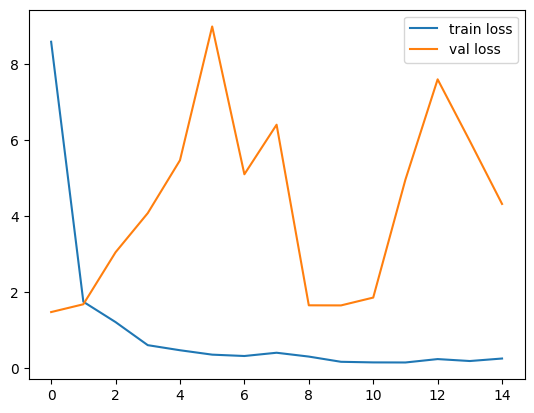

In [23]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

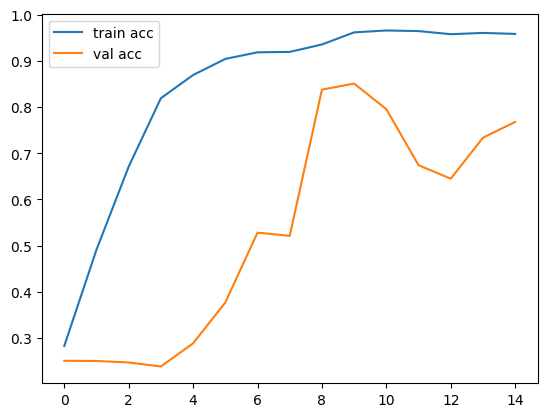

In [24]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [25]:
# gives us back our best model
model.load_weights(checkpoint_filepath)

In [29]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in val_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=True, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    p = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets,y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [31]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print('Generatin confusion matirx', N)
  predictions = []
  targets = []
  i = 0
  n_images = 0
  for x, y in val_gen.flow_from_directory(
      data_path,
      target_size=IMAGE_SIZE,
      shuffle=False,
      batch_size=batch_size * 2):
    i += 1
    n_images += len(y)
    if i % 50 == 0:
      print(f'{n_images} images proceeded.')
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions,p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [32]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generatin confusion matirx 9957
Found 9957 images belonging to 4 classes.
8/8 [==============================] - 1s 93ms/step
[[2403   32    0   62]
 [   2 2481    0    0]
 [  28   88 2313   49]
 [ 142   45    1 2311]]


In [33]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generatin confusion matirx 2487
Found 2487 images belonging to 4 classes.
6/6 [==============================] - 1s 154ms/step
[[533  42   0  48]
 [ 25 593   1   1]
 [  0   0 465 155]
 [ 76  23   0 525]]


In [34]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'.
  """
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment='center',
              color='white' if cm[i, j] > thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


Confusion matrix, without normalization
[[2403   32    0   62]
 [   2 2481    0    0]
 [  28   88 2313   49]
 [ 142   45    1 2311]]


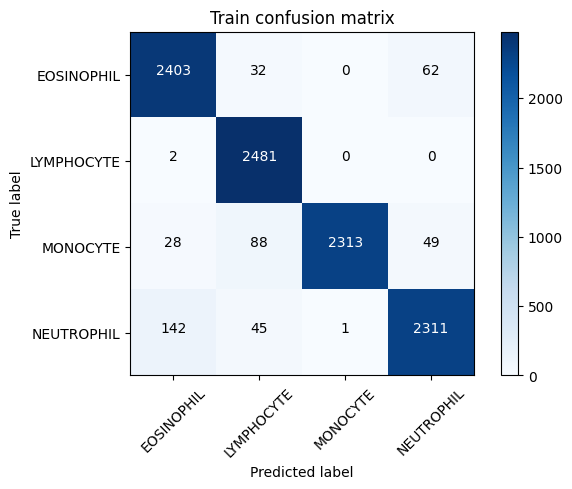

In [35]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')

In [36]:
# compute tha acc for the train set using the confusion matrix
np.trace(cm) / cm.sum()

0.954906096213719

Confusion matrix, without normalization
[[533  42   0  48]
 [ 25 593   1   1]
 [  0   0 465 155]
 [ 76  23   0 525]]


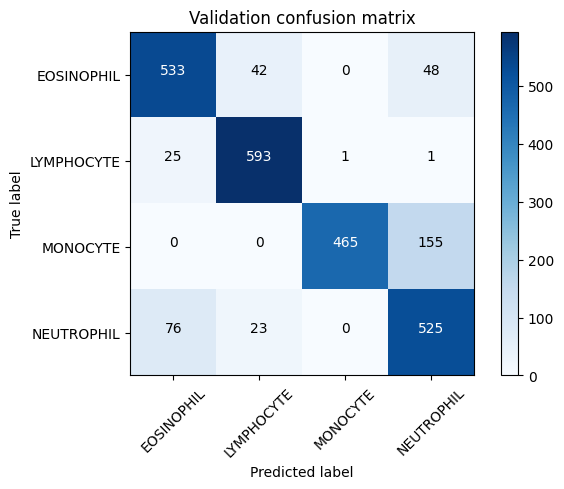

In [37]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [38]:
# acc for the validation set
np.trace(valid_cm) / valid_cm.sum()

0.8508242862887012